# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
import librosa
from scipy.signal import spectrogram

import pandas as pd
import geopandas as gpd
import contextily as cx

import scipy as scp

from scipy.spatial.distance import pdist, squareform 
from math import radians
import seaborn as sns
from pygsp import graphs
from scipy.linalg import eigh

import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors

from loadmydata.load_molene_meteo import load_molene_meteo_dataset

from loadmydata.load_molene_meteo import load_molene_meteo_dataset

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [309]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [310]:
signal, symbols = X_train[38], y_train[38]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

1 6 4 1 D * 8 0 6


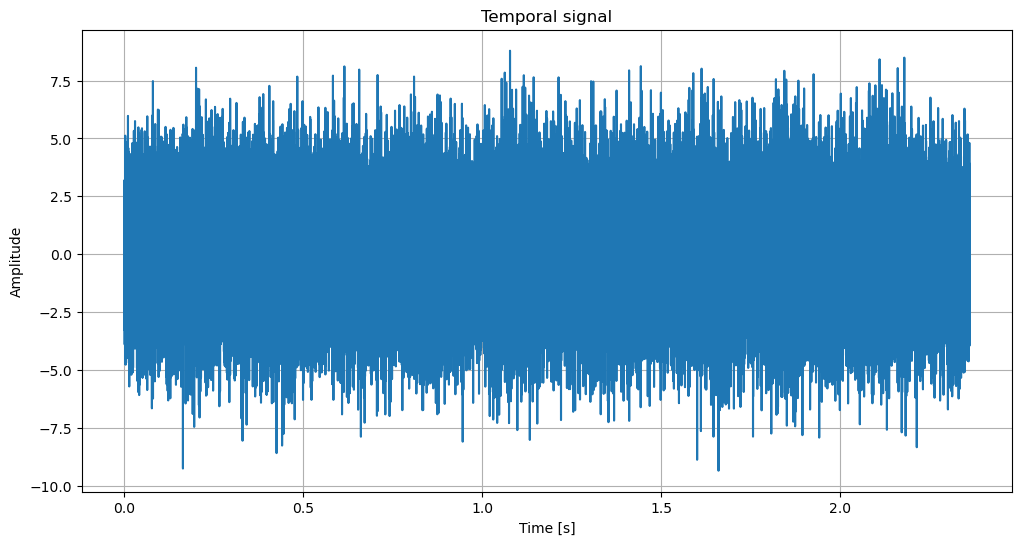

In [311]:
plt.figure(figsize=(12, 6))
time = np.arange(len(signal)) / FS

plt.plot(time, signal)
plt.title('Temporal signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

There is not much we can do we the temporal signal : $\textbf{we therefore work with the signals' spectograms}$. 

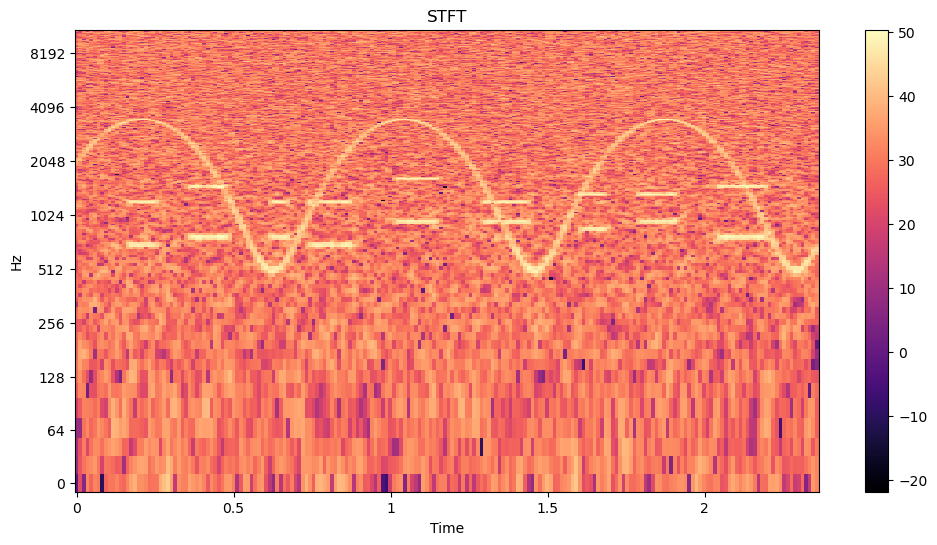

In [312]:
n_fft = 1024 
hop_length = 256  

stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

stft_db = librosa.amplitude_to_db(np.abs(stft))

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_db, sr=FS, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('STFT')
plt.show()

## Retrieve $F_1$ and $F_2$

First, we need to retrieve $F_1$ and $F_2$, the respective sets of frequencies for $f_1$ and $f_2$. 

In [314]:
spectra = np.zeros(int(1024 / 2) + 1) 

for signal in X_train:

    frequencies, times, Sxx = spectrogram(signal, FS, nperseg=1024)
    spectra += np.mean(Sxx, axis=1)

average_spectra = spectra / 100

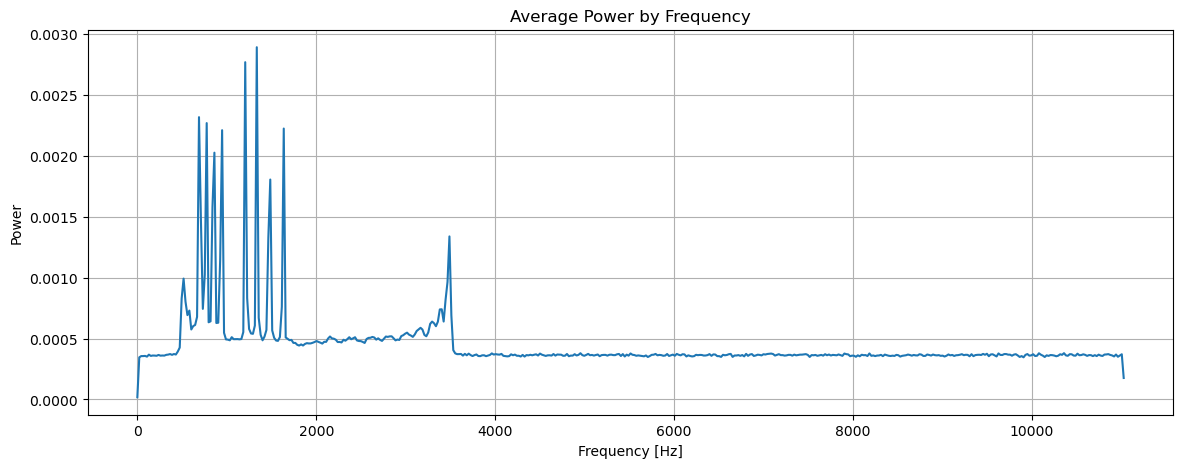

In [315]:
plt.figure(figsize=(14, 5))
plt.plot(frequencies, average_spectra)
plt.title('Average Power by Frequency')
plt.ylabel('Power')
plt.xlabel('Frequency [Hz]')
plt.grid(True)
plt.show()

In [316]:
largest_indices = get_n_largest(average_spectra, n_largest=8)[1]

largest_frequencies = frequencies[largest_indices]
largest_frequencies = np.sort(largest_frequencies)
F1_set = largest_frequencies[0:4]
F2_set = largest_frequencies[4:8]

print(rf"The estimated F_1 set is: {F1_set}")
print(rf"The estimated F_2 set is: {F2_set}")

The estimated F_1 set is: [689.0625    775.1953125 861.328125  947.4609375]
The estimated F_2 set is: [1205.859375   1335.05859375 1485.79101562 1636.5234375 ]


## DTMF Keypad

In fact, we can find the DTMF Keypad Frequencies by reading the page from the [link](https://en.wikipedia.org/wiki/DTMF) :

|          | 1209 Hz | 1336 Hz | 1477 Hz | 1633 Hz |
|----------|---------|---------|---------|---------|
| **697 Hz** | 1       | 2       | 3       | A       |
| **770 Hz** | 4       | 5       | 6       | B       |
| **852 Hz** | 7       | 8       | 9       | C       |
| **941 Hz** | *       | 0       | #       | D       |

In [317]:
F1_set = [697.0, 770.0, 852.0, 941.0]
F2_set = [1209.0, 1336.0, 1477.0, 1633.0]

In [383]:
symbols_to_freqs = {
    "1": (697, 1209),
    "2": (697, 1336),
    "3": (697, 1477),
    "A": (697, 1633),
    "4": (770, 1209),
    "5": (770, 1336),
    "6": (770, 1477),
    "B": (770, 1633),
    "7": (852, 1209),
    "8": (852, 1336),
    "9": (852, 1477),
    "C": (852, 1633),
    "*": (941, 1209),
    "0": (941, 1336),
    "#": (941, 1477),
    "D": (941, 1633),
}   

freqs_to_symbols = {v: k for k, v in symbols_to_freqs.items()}

## Pipeline

In [375]:
def calculate_energy(signal: np.ndarray) -> np.ndarray:
    """ 
    Calculate the energy of the signal at the given frequencies.
    """
    
    n_fft = 2048
    hop_length = 256
    threshold_intensity = 45

    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

    stft_db = librosa.amplitude_to_db(np.abs(stft))
    copy = np.copy(stft_db)
    for i in range(stft_db.shape[0]):
        for j in range(stft_db.shape[1]):
            if (copy[i][j] >= threshold_intensity):
                copy[i][j] = copy[i][j]
            else:
                copy[i][j] = 0

    corresponding_indices = [65, 72, 79, 87, 112, 124, 137, 152] # indices corresponding to the frequencies in the stft_db

    energy = np.zeros(stft_db.shape[1])
    for i in range(len(copy.T)):
        energy[i] = np.sum(copy.T[i][corresponding_indices])

    return energy

In [426]:
def find_bkps(energy, threshold_energy):
    """
    Retrieve the breakpoints of the energy signal.
    A breakpoint = the instant the energy signal passes over or under the threshold.
    threshold_energy is a hyperparameter we set using the training set. 
    """
    bkps = []
    for i in range(1, len(energy)):
        product = (energy[i] - threshold_energy) * (energy[i - 1] - threshold_energy)
        if product < 0:
            bkps.append(i)
    return bkps

In [443]:
def find_symbol(signal, bkps, freqs_to_symbols):
    """
    Find the symbols corresponding to the energy signal.
    """

    symbol = ""
    signal_stft = librosa.stft(signal, n_fft=2048, hop_length=256)
    stft_db = librosa.amplitude_to_db(np.abs(signal_stft))
    freqs = np.arange(0, 1 + n_fft / 2) * FS / n_fft

    for i in range(0, len(bkps), 2):
        start = bkps[i]
        end = bkps[i + 1]
        index_time = int((start + end) / 2) # index corresponding to the frame in the middle of the symbol

        index_1 = np.argsort(stft_db[64:90].T)[index_time][-1] + 64
        index_2 = np.argsort(stft_db[110:155].T)[index_time][-1] + 110

        freq = freqs[index_1], freqs[index_2]
      
        #find the closest frequencies to the frequencies of the symbols
        closest_freqs = (697, 1209)
        for couple in freqs_to_symbols.keys():
            if np.linalg.norm(freq - np.array(couple)) < np.linalg.norm(freq - np.array(closest_freqs)):
                closest_freqs = couple
        symbol += freqs_to_symbols[tuple(closest_freqs)]
    return symbol

In [470]:
def decode(signal, threshold_energy=93, freqs_to_symbols=freqs_to_symbols):
    """
    Decode the signal.
    """
    energy = calculate_energy(signal)
    bkps = find_bkps(energy, threshold_energy)
    symbol = find_symbol(signal, bkps, freqs_to_symbols)
    output = []
    for letter in symbol:
        output.append(letter)
    return output

## Computation of the precision

In [471]:
# computation of the precision of the decoding
precision = 0

for i in range(len(X_train)):
    signal = X_train[i]
    symbols = y_train[i]
    decoded_symbols = decode(signal)
    if symbols == decoded_symbols:
        precision += 1
    else : 
        print(f"Signal {i} : {symbols} -> {decoded_symbols}")
    
print(f"Precision: {precision / len(X_train)}")  

Precision: 1.0


We have a precision of 100% on the training set ! 

# Question 2

In [474]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
print('We now decode the signals of the test set :')
for i in range(len(X_test)):
    signal = X_test[i]
    decoded_symbols = decode(signal)
    print(f"Signal {i} : {decoded_symbols}")

We now decode the signals of the test set :
Signal 0 : ['7', '2', '1', 'C', '9', '9']
Signal 1 : ['1', '#', '2', '#']


# Question 3

In [2]:
lambda_n = 12
M = 9

In [3]:
def g_m(lambdas : np.ndarray, ms : np.ndarray, R : float = 1, lambda_n : float = 12.):
    """ 
    Inputs:
        lambdas: np.ndarray of size (N)
        ms: np.ndarray of size (M)
        R: float, kernel parameter
        lambda_n: float, maximal eigenvalue
    Returns an array of size (M, N) with (g_m(l)) for l in lambdas, m in ms
    """
    N = lambdas.shape[0]
    M = ms.shape[0]
    a = lambda_n / (M + 1 - R)

    m = np.repeat(ms, N).reshape((M,N))
    l = np.repeat(lambdas, M).reshape((N,M)).T

    mask1 = (l >= 0) * (l <= lambda_n) * 1.
    mask2 = (l - a * m < 0) * (l - a * m >= - R * a) * 1.
    result = 1/2 * (1 + np.cos(2 * np.pi * ( (l - a * m)/(R * a) + 1/2)))
    return mask1 * mask2 * result

In [4]:
def plot_g_m(M, R : float = 1., lambda_n : float = 12.):
    X = np.linspace(0, lambda_n, 1000)
    Y = g_m(X, ms = np.arange(1, M + 1), R = R, lambda_n = lambda_n)

    plt.figure(figsize=(8, 5))
    for m in range(M):
        plt.plot(X, Y[m], label=f"$m={m+1}$")

    plt.title(r"$\hat g_m(\lambda)$, $R={}$".format(R))
    plt.xlabel(r"$\lambda$")
    plt.legend()
    plt.show()

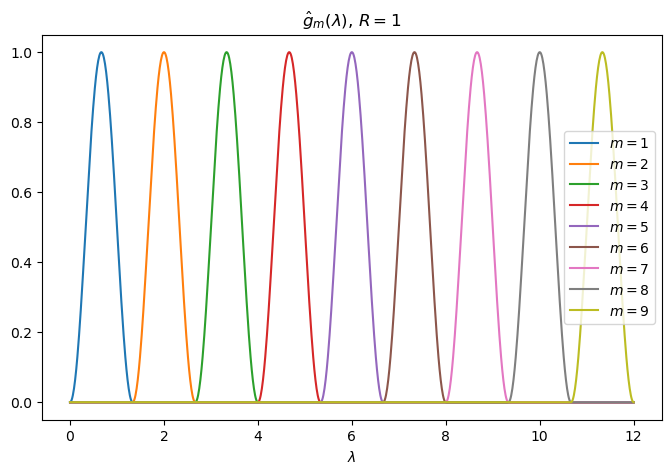

In [5]:
plot_g_m(M, R=1, lambda_n=lambda_n)

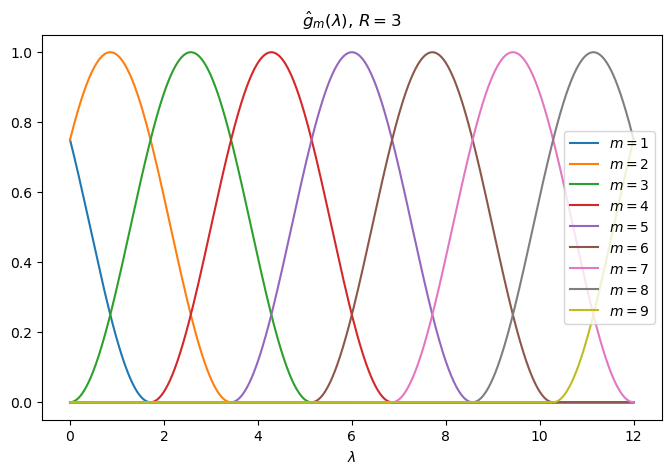

In [6]:
plot_g_m(M, R=3, lambda_n=lambda_n)

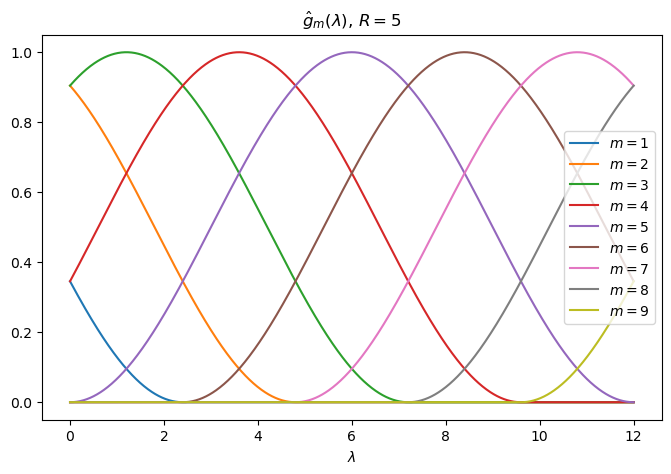

In [7]:
plot_g_m(M, R=5, lambda_n=lambda_n)

# Question 4

In [ ]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [ ]:
# Convert the temperature to Celsius
data_df["t"] = data_df["t"] - 273.15

In [ ]:
# Remove stations with missing values in the temperature

data_df_pivot = data_df.pivot(index='date', columns='station_name', values='t')           # I used a pivot table, since some stations do not have rows for some dates, and these dont show up as nans in data_df
missing_stations = data_df_pivot.columns[data_df_pivot.isna().sum() > 0]
print(f"Stations with missing values in the temperature: {missing_stations}")
print(f"Number of stations with missing values in the temperature: {len(missing_stations)}")

data_df_nomiss = data_df[~data_df['station_name'].isin(missing_stations)]
stations_df_nomiss = stations_df[~stations_df['Nom'].isin(missing_stations)]

Stations with missing values in the temperature: Index(['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET',
       'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA',
       'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN',
       'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON'],
      dtype='object', name='station_name')
Number of stations with missing values in the temperature: 18


In [ ]:
# Utility functions used to get the weight matrices if the graphs

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [ ]:
# Create the distance matrix between the remaining stations

stations_gdf = gpd.GeoDataFrame(
    stations_df_nomiss,
    geometry=gpd.points_from_xy(stations_df_nomiss.Longitude, stations_df_nomiss.Latitude),
)
stations_gdf.set_crs(epsg=4326, inplace=True)
# Sort alphabetically by station name so that we don't get lost later when dealing with matrix multiplications

stations_np = stations_gdf[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat = squareform(dist_mat_condensed)

In [ ]:
# Create the pivot table with the temperature data for the remaining stations. 

data_df_pivot_nomiss = data_df_pivot[stations_df_nomiss["Nom"]]
data_df_pivot_nomiss.head()

station_name,ILE-DE-BREHAT,KERPERT,LOUARGAT,MERDRIGNAC,PLOUMANAC'H,PLOUGUENAST,POMMERIT-JAUDY,QUINTENIC,ROSTRENEN,SAINT-CAST-LE-G,...,ILE DE GROIX,GUISCRIFF SA,PLEUCADEUC,PLOERMEL,PONTIVY,LORIENT-LANN BIHOUE,SARZEAU SA,VANNES-SENE,THEIX,NOIRMOUTIER EN
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,7.0,5.9,7.2,6.1,7.4,5.9,7.1,6.8,6.8,6.1,...,9.0,8.3,8.3,7.6,7.2,9.0,9.8,9.7,9.3,9.5
2014-01-01 01:00:00,7.0,5.9,6.9,5.5,7.8,6.2,7.6,6.7,6.9,6.3,...,10.0,7.8,8.4,7.9,8.1,10.0,9.9,9.9,9.1,9.6
2014-01-01 02:00:00,7.8,6.4,7.4,6.1,8.1,6.4,7.8,7.5,6.9,6.4,...,9.5,8.4,8.7,8.2,7.4,8.9,9.2,9.6,9.4,9.6
2014-01-01 03:00:00,8.3,6.7,7.7,5.9,8.4,6.9,8.3,7.8,7.3,7.0,...,10.4,8.4,8.2,8.2,8.1,10.1,10.1,9.8,8.9,9.7
2014-01-01 04:00:00,8.9,6.9,8.3,6.7,8.8,6.9,8.9,8.1,7.2,7.7,...,10.8,8.9,8.8,8.6,8.2,10.4,10.5,10.2,9.6,9.5


In [ ]:
# Note that the stations in data_df_pivot_nomiss are in the same order as in stations_gdf. 
# This means that we can do matrix multiplication with the rows of the pivot table and the distance matrices (we are not multiplying irrelevant quantities together).

stations_gdf["Nom"].to_numpy()

array(['ILE-DE-BREHAT', 'KERPERT', 'LOUARGAT', 'MERDRIGNAC',
       "PLOUMANAC'H", 'PLOUGUENAST', 'POMMERIT-JAUDY', 'QUINTENIC',
       'ROSTRENEN', 'SAINT-CAST-LE-G', 'ST BRIEUC', 'MORLAIX_AERO',
       'PTE DE PENMARCH', 'PLEYBER-CHRIST SA', 'PTE DU RAZ', 'PLOVAN',
       'ST-SEGAL S A', 'SIBIRIL S A', 'SPEZET', 'TREGUNC', 'DINARD',
       'GUERANDE', 'SAINT-JOACHIM_SAE', 'PTE DE CHEMOULIN', 'AURAY',
       'BELLE ILE-LE TALUT', 'BIGNAN', 'ILE DE GROIX', 'GUISCRIFF SA',
       'PLEUCADEUC', 'PLOERMEL', 'PONTIVY', 'LORIENT-LANN BIHOUE',
       'SARZEAU SA', 'VANNES-SENE', 'THEIX', 'NOIRMOUTIER EN'],
      dtype=object)

In [ ]:
# Find the minimum threshold such that the graph is connected and the average degree is greater than 3

sigma = np.median(dist_mat)      # median heuristic for the bandwidth

connected = False
avg_deg = 0
thresholds = np.round(np.linspace(1, 0.82, 100), 2)

for thresh in thresholds:
    adjacency_matrix_gaussian = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, thresh)
    )
    G = graphs.Graph(adjacency_matrix_gaussian)
    connected = G.is_connected()
    avg_deg = np.mean(G.d)
    
    if connected and avg_deg > 3:
        break


print(f"Threshold: {thresh}")
print(f"Connected: {connected}")
print(f"Average degree: {avg_deg}")

Threshold: 0.82
Connected: True
Average degree: 4.054054054054054


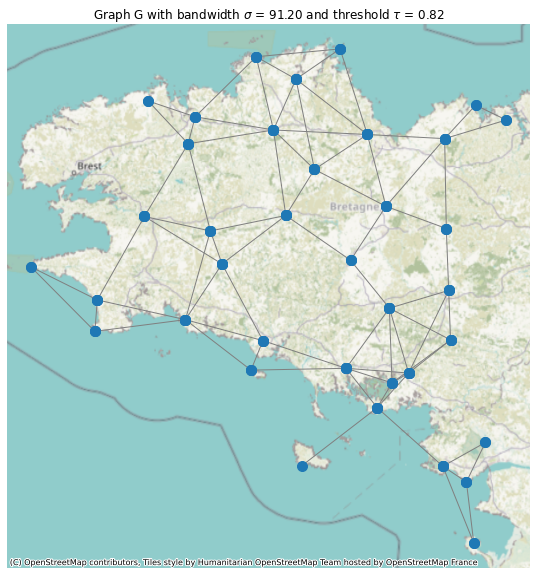

In [ ]:
# Plot the corresponding graph G

ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

G.set_coordinates(stations_np)
G.plot(ax=ax)
plt.title(r"Graph G with bandwidth $\sigma$ = {:.2f} and threshold $\tau$ = {:.2f}".format(sigma, thresh))
plt.show()

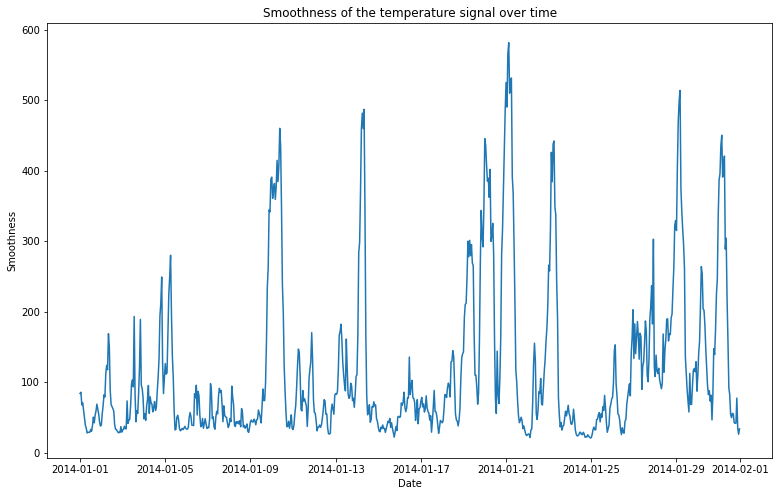

In [ ]:
# Compute the signal's smoothness over time

L = G.L.todense()

def S(x):
    return (x.T @ L @ x).item()

dates = data_df_nomiss['date'].unique()
temps = data_df_pivot_nomiss.to_numpy()
smoothness = [S(temps[i]) for i in range(temps.shape[0])]                  # We checked earlier that the ordering of the stations is the same for the vectors temps[i] and the graph laplacian

plt.figure(figsize=(13, 8))
plt.plot(dates, smoothness)
plt.xlabel("Date")
plt.ylabel("Smoothness")
plt.title("Smoothness of the temperature signal over time")
plt.show()

In [ ]:
# Signicant dates

least_smooth = np.argmax(smoothness)
most_smooth = np.argmin(smoothness)

print(f"The signal is the least smooth at {dates[least_smooth]}. Smoothness value: {smoothness[least_smooth]}")
print(f"The signal is the most smooth at {dates[most_smooth]}. Smoothness value: {smoothness[most_smooth]}")

The signal is the least smooth at 2014-01-21 02:00:00. Smoothness value: 722.5942535489654
The signal is the most smooth at 2014-01-22 03:00:00. Smoothness value: 26.32121962927813


# Question 5

In [ ]:
def W_f(G : graphs.Graph, f : np.ndarray, R : float = 3., M : int = 9):
    """ 
    Returns the matrix (W_f(m,v)) of shape (M, N) given a graph G, a signal f (of shape (N)), a kernel parameter R, and M.
    """
    lambdas, U = eigh(G.L.todense())
    lambda_n = lambdas[-1]

    ms = np.arange(1, M + 1)

    g_ms = g_m(lambdas, ms, R = R, lambda_n = lambda_n)       # Of shape (M, N)
    f_hat = np.diag(U.T @ f)                                  # Of shape (N, N)

    Wf = g_ms @ f_hat @ U                                     # Of shape (M, N)
    return Wf


def get_classes(G : graphs.Graph, f : np.ndarray):
    Wf = W_f(G = G, f = f, R = 3., M = 9)

    energy = Wf**2
    energy_1 = np.sum(energy[:3], axis=0)
    energy_2 = np.sum(energy[3:6], axis=0)
    energy_3 = np.sum(energy[6:], axis=0)
    energy_concat = np.vstack([energy_1, energy_2, energy_3])

    classes = np.argmax(energy_concat, axis=0)
    return classes


def plot_classes(date):
    signal = data_df_nomiss['t'].loc[data_df_nomiss['date'] == date].to_numpy()
    classes = get_classes(G, signal)
    
    labels = ["Low frequency", "Medium frequency", "High frequency"]
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(labels)))
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]

    plt.figure(figsize=(10, 10))
    ax = stations_gdf.geometry.plot(figsize=(10, 10))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()

    G.set_coordinates(stations_np)
    G.plot_signal(classes, ax=ax, colorbar = False, limits = [0,2])

    plt.title(f"Classes of the stations at {date}")
    plt.legend(handles=patches, title="Frequency Classes", loc="upper left", fontsize=10, title_fontsize=12)
    plt.show()

<Figure size 720x720 with 0 Axes>

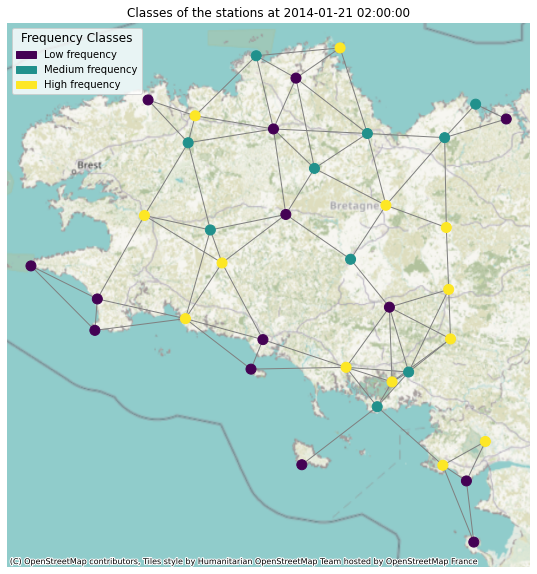

In [ ]:
# Plot the classes for the least smooth signal

date = dates[least_smooth]
plot_classes(date)

<Figure size 720x720 with 0 Axes>

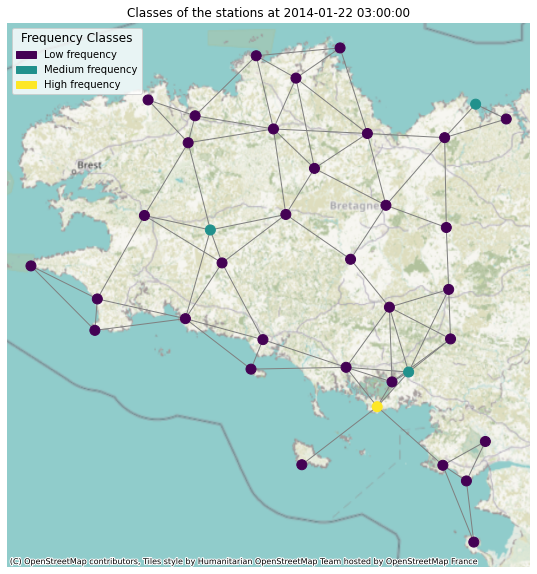

In [ ]:
# Plot the classes for the smoothest signal

date = dates[most_smooth]
plot_classes(date)

<Figure size 720x720 with 0 Axes>

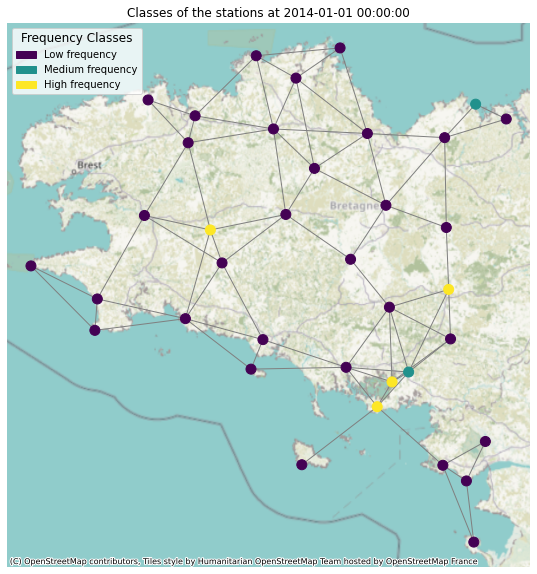

In [ ]:
# Plot the classes for the first available timestamp

date = dates[0]
plot_classes(date)

# Question 6

In [ ]:
def majority_class(G : graphs.Graph, f : np.ndarray):
    classes = get_classes(G, f)
    bins = np.bincount(classes)
    majority = np.argmax(bins)
    return majority

In [ ]:
dates = data_df_nomiss['date'].unique()
majority_classes = [majority_class(G, data_df_nomiss['t'].loc[data_df_nomiss['date'] == date].to_numpy()) for date in dates]

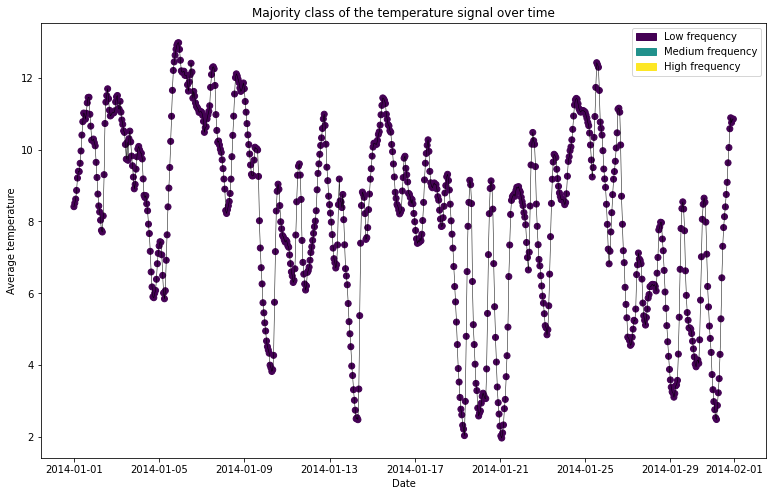

In [ ]:
average_temp = np.mean(data_df_pivot_nomiss.to_numpy(), axis=1)

cmap = cm.viridis
colors = cmap(np.linspace(0, 1, 3))
labels = ["Low frequency", "Medium frequency", "High frequency"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]

plt.figure(figsize=(13, 8))
plt.plot(dates, average_temp, label="Average temperature", c = "black", linewidth=.5)
plt.scatter(dates, average_temp, c=majority_classes, cmap=cm.viridis, label="Majority class")
plt.xlabel("Date")
plt.ylabel("Average temperature")
plt.title("Majority class of the temperature signal over time")
plt.legend(handles=patches)

# Question 7

In [ ]:
# Create a signal of size T*N with the temperature of each station at each timestamp
f = data_df_pivot_nomiss.to_numpy().reshape(-1)

# The first N values are the temperature of each station at the first timestamp, the next N values are the temperature of each station at the second timestamp, and so on.
f

array([ 7. ,  5.9,  7.2, ..., 11.4, 11.3, 10. ])

In [ ]:
T = len(dates)
N = len(stations_gdf)

In [ ]:
# Laplacian of the temporal graph G'

A_G_prime = np.diag(np.ones(T - 1), 1) + np.diag(np.ones(T - 1), -1)
D_G_prime = 2 * np.eye(T)
D_G_prime[0, 0] = 1
D_G_prime[T - 1, T - 1] = 1
L_G_prime = D_G_prime - A_G_prime

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [ ]:
# Eigenvalues and eigenvectors of the Laplacians of G and G'

lambda_G, U_G = eigh(G.L.todense())
lambda_G_prime, U_G_prime = eigh(L_G_prime)

In [ ]:
lambda_G_repeat = np.vstack([lambda_G] * T).reshape(-1)
lambda_G_prime_repeat = np.repeat(lambda_G_prime, N)

# Vector of lambda_G_n + lambda_G_prime_t for all n and t
lambdas = lambda_G_repeat + lambda_G_prime_repeat

In [ ]:
# Compute the g_m matrix, of shape (M, N*T)
lambda_n = lambda_G[-1]
gm = g_m(lambdas, ms = np.arange(1, M + 1), R = 3, lambda_n = lambda_n)
gm.shape

(9, 27528)

In [ ]:
# Compute the fourier transform of f
f_hat = np.kron(U_G_prime.T, U_G.T) @ f

In [ ]:
# Compute Wf
Wf = gm @ np.diag(f_hat) @ np.kron(U_G_prime, U_G)

In [ ]:
# Get energies
energy = Wf**2
energy_1 = np.sum(energy[:3], axis=0)
energy_2 = np.sum(energy[3:6], axis=0)
energy_3 = np.sum(energy[6:], axis=0)
energy_concat = np.vstack([energy_1, energy_2, energy_3])

# Get classes
classes = np.argmax(energy_concat, axis=0)
classes.shape

(27528,)

In [ ]:
# Get majority classes for each time step
majority_classes = np.zeros(T)
for t in range(T):
    majority_classes[t] = np.argmax(np.bincount(classes[t * N: (t + 1) * N]))

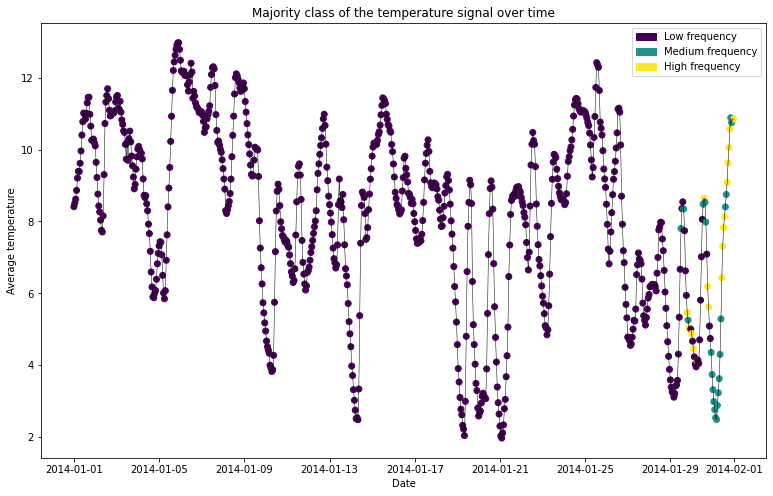

In [ ]:
# Plot the average temperature at each timestep and the majority classes

average_temp = np.mean(data_df_pivot_nomiss.to_numpy(), axis=1)

cmap = cm.viridis
colors = cmap(np.linspace(0, 1, 3))
labels = ["Low frequency", "Medium frequency", "High frequency"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(3)]

plt.figure(figsize=(13, 8))
plt.plot(dates, average_temp, label="Average temperature", c = "black", linewidth=.5)
plt.scatter(dates, average_temp, c=majority_classes, cmap=cm.viridis, label="Majority class")
plt.xlabel("Date")
plt.ylabel("Average temperature")
plt.title("Majority class of the temperature signal over time")
plt.legend(handles=patches)